In [1]:
import sys
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
np.random.seed(1234)
tf.random.set_seed(1234)

In [12]:
import tensorflow as tf
import numpy as np

class PhysicsInformedNN:
    def __init__(self, x0, u0, x1, u1, layers, dt, lb, ub, q):
        self.lb = tf.cast(lb, dtype=tf.float32)
        self.ub = tf.cast(ub, dtype=tf.float32)
        self.x0 = tf.cast(x0, dtype=tf.float32)
        self.x1 = tf.cast(x1, dtype=tf.float32)
        self.u0 = tf.cast(u0, dtype=tf.float32)
        self.u1 = tf.cast(u1, dtype=tf.float32)
        self.layers = layers
        self.dt = tf.cast(dt, dtype=tf.float32)
        self.q = max(q, 1)

        # Initialize neural network weights and biases
        self.weights, self.biases = self.initialize_NN(layers)

        # Physics parameters (lambda_1 and lambda_2)
        self.lambda_1 = tf.Variable(0.0, dtype=tf.float32)
        self.lambda_2 = tf.Variable(-6.0, dtype=tf.float32)

        # Load IRK weights (assuming Butcher table is in the proper format)
        tmp = np.loadtxt('Butcher_IRK%d.txt' % (q), dtype=np.float32, ndmin=2)
        weights = np.reshape(tmp[0:q**2 + q], (q + 1, q))
        self.IRK_alpha = tf.convert_to_tensor(weights[0:-1, :], dtype=tf.float32)
        self.IRK_beta = tf.convert_to_tensor(weights[-1:, :], dtype=tf.float32)
        self.IRK_times = tf.convert_to_tensor(tmp[q**2 + q:], dtype=tf.float32)

        # Optimizer and loss function
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_metric = tf.keras.metrics.Mean(name='loss')

    def initialize_NN(self, layers):
        """Initialize network weights and biases."""
        initializer = tf.keras.initializers.GlorotNormal()
        weights = []
        biases = []
        for l in range(len(layers) - 1):
            W = tf.Variable(initializer(shape=(layers[l], layers[l + 1])), dtype=tf.float32)
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def neural_net(self, X):
        """Forward pass through the neural network."""
        H = tf.cast(X, dtype=tf.float32)  # Ensure input is float32
        for l in range(len(self.weights) - 1):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))  # Apply tanh activation
        W = self.weights[-1]
        b = self.biases[-1]
        U = tf.add(tf.matmul(H, W), b)  # No activation for the output layer
        return U

    def net_U0(self, x):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            U = self.neural_net(x)
            U_x = tape.gradient(U, x)
            U_xx = tape.gradient(U_x, x)
            U_xxx = tape.gradient(U_xx, x)
        # Удаляем GradientTape после его использования
        del tape
        
        lambda_1_casted = tf.cast(self.lambda_1, dtype=U.dtype)
        lambda_2_casted = tf.exp(self.lambda_2)
        
        return - lambda_1_casted * U * U_x - lambda_2_casted * U_xxx


    def net_U1(self, x):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            U = self.neural_net(x)
            U_x = tape.gradient(U, x)
            U_xx = tape.gradient(U_x, x)
            U_xxx = tape.gradient(U_xx, x)
        # Удаляем GradientTape после использования
        del tape
        
        lambda_1_casted = tf.cast(self.lambda_1, dtype=U.dtype)
        lambda_2_casted = tf.exp(self.lambda_2)
        
        return - lambda_1_casted * U * U_x - lambda_2_casted * U_xxx


    @tf.function
    def train_step(self, x0, u0, x1, u1):
        """Single training step."""
        with tf.GradientTape(persistent=True) as tape:
            U0_pred = self.net_U0(x0)
            U1_pred = self.net_U1(x1)

            # Compute the loss (mean squared error)
            loss = tf.reduce_mean(tf.square(u0 - U0_pred)) + tf.reduce_mean(tf.square(u1 - U1_pred))

        gradients = tape.gradient(loss, [self.lambda_1, self.lambda_2] + self.weights + self.biases)
        self.optimizer.apply_gradients(zip(gradients, [self.lambda_1, self.lambda_2] + self.weights + self.biases))

        self.loss_metric(loss)
        return loss

    def train(self, nIter):
        for it in range(nIter):
            loss_value = self.train_step(self.x0, self.u0, self.x1, self.u1)
            if it % 100 == 0:
                print(f'Iter: {it}, Loss: {self.loss_metric.result()}')
                self.loss_metric.reset_state()

    def predict(self, x_star):
        """Make predictions for the inputs."""
        x_star = tf.convert_to_tensor(x_star, dtype=tf.float32)  # Конвертируем x_star в тензор
        U0_star = self.net_U0(x_star)
        U1_star = self.net_U1(x_star)
        return U0_star, U1_star

In [27]:
# Параметры модели
q = 10
N0 = 199
N1 = 201
layers = [1, 50, 50, 50, 50, q]

# Загрузка данных
data = scipy.io.loadmat('KdV.mat')
t_star = data['tt'].flatten()[:, None]
x_star = data['x'].flatten()[:, None]
Exact = np.real(data['uu'])

# Индексы для временного момента
idx_t = 40
noise = 0.0

# Генерация начальных данных с шумом для двух временных моментов
idx_x = np.random.choice(Exact.shape[0], N0, replace=False)
x0 = x_star[idx_x, :]
u0 = Exact[idx_x, idx_t][:, None] + noise * np.std(Exact) * np.random.randn(N0, 1)

idx_x = np.random.choice(Exact.shape[0], N1, replace=False)
x1 = x_star[idx_x, :]
u1 = Exact[idx_x, idx_t + 120][:, None] + noise * np.std(Exact) * np.random.randn(N1, 1)

# Разница во времени
dt = t_star[idx_t + 120] - t_star[idx_t]

# Границы области
lb = x_star.min(0)
ub = x_star.max(0)

# Обучение модели
model = PhysicsInformedNN(x0, u0, x1, u1, layers, dt, lb, ub, q)
model.train(nIter=10000)

# Прогнозирование
U0_pred, U1_pred = model.predict(x_star)

# Извлечение значений параметров λ
lambda_1_value = model.lambda_1.numpy()
lambda_2_value = tf.exp(model.lambda_2).numpy()

# Вычисление ошибок
error_lambda_1 = np.abs(lambda_1_value - 1.0) / 1.0 * 100
error_lambda_2 = np.abs(lambda_2_value - 0.0025) / 0.0025 * 100

# Вывод ошибок
print(f'Error lambda_1: {error_lambda_1}%')
print(f'Error lambda_2: {error_lambda_2}%')

Iter: 0, Loss: 0.9954395294189453
Iter: 100, Loss: 0.5401908755302429
Iter: 200, Loss: 0.27954164147377014
Iter: 300, Loss: 0.26021671295166016
Iter: 400, Loss: 0.24122896790504456
Iter: 500, Loss: 0.2290492057800293
Iter: 600, Loss: 0.22799387574195862
Iter: 700, Loss: 0.2274661660194397
Iter: 800, Loss: 0.2266879677772522
Iter: 900, Loss: 0.22545744478702545
Iter: 1000, Loss: 0.22479934990406036
Iter: 1100, Loss: 0.22455012798309326
Iter: 1200, Loss: 0.22446449100971222
Iter: 1300, Loss: 0.22438254952430725
Iter: 1400, Loss: 0.22424235939979553
Iter: 1500, Loss: 0.2241581529378891
Iter: 1600, Loss: 0.22422415018081665
Iter: 1700, Loss: 0.223931223154068
Iter: 1800, Loss: 0.22421537339687347
Iter: 1900, Loss: 0.22388435900211334
Iter: 2000, Loss: 0.22390097379684448
Iter: 2100, Loss: 0.22406959533691406
Iter: 2200, Loss: 0.22389350831508636
Iter: 2300, Loss: 0.22392871975898743
Iter: 2400, Loss: 0.2239689975976944
Iter: 2500, Loss: 0.22369316220283508
Iter: 2600, Loss: 0.2238678932189

In [28]:
######################################################################
########################### Данные с шумом ############################
######################################################################
model = PhysicsInformedNN(x0, u0, x1, u1, layers, dt, lb, ub, q)
model.train(nIter=10000)

# Прогнозирование
U0_pred, U1_pred = model.predict(x_star)

# Извлечение значений параметров λ для данных с шумом
lambda_1_value_noisy = model.lambda_1.numpy()
lambda_2_value_noisy = tf.exp(model.lambda_2).numpy()

# Вычисление ошибок для данных с шумом
error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0) / 1.0 * 100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - 0.0025) / 0.0025 * 100

# Вывод ошибок для данных с шумом
print(f'Error lambda_1 (with noise): {error_lambda_1_noisy}%')
print(f'Error lambda_2 (with noise): {error_lambda_2_noisy}%')

Iter: 0, Loss: 0.9987982511520386
Iter: 100, Loss: 0.5716659426689148
Iter: 200, Loss: 0.2652949392795563
Iter: 300, Loss: 0.25056254863739014
Iter: 400, Loss: 0.22880437970161438
Iter: 500, Loss: 0.22608596086502075
Iter: 600, Loss: 0.22465816140174866
Iter: 700, Loss: 0.22440806031227112
Iter: 800, Loss: 0.2243083417415619
Iter: 900, Loss: 0.22425325214862823
Iter: 1000, Loss: 0.22419053316116333
Iter: 1100, Loss: 0.22399665415287018
Iter: 1200, Loss: 0.22407034039497375
Iter: 1300, Loss: 0.2240028828382492
Iter: 1400, Loss: 0.22386223077774048
Iter: 1500, Loss: 0.22394737601280212
Iter: 1600, Loss: 0.2239113450050354
Iter: 1700, Loss: 0.22377315163612366
Iter: 1800, Loss: 0.2238679677248001
Iter: 1900, Loss: 0.22378262877464294
Iter: 2000, Loss: 0.22370551526546478
Iter: 2100, Loss: 0.22384725511074066
Iter: 2200, Loss: 0.22353902459144592
Iter: 2300, Loss: 0.22385801374912262
Iter: 2400, Loss: 0.2233564406633377
Iter: 2500, Loss: 0.2236439734697342
Iter: 2600, Loss: 0.2235402166843

TypeError: unsupported format string passed to numpy.ndarray.__format__

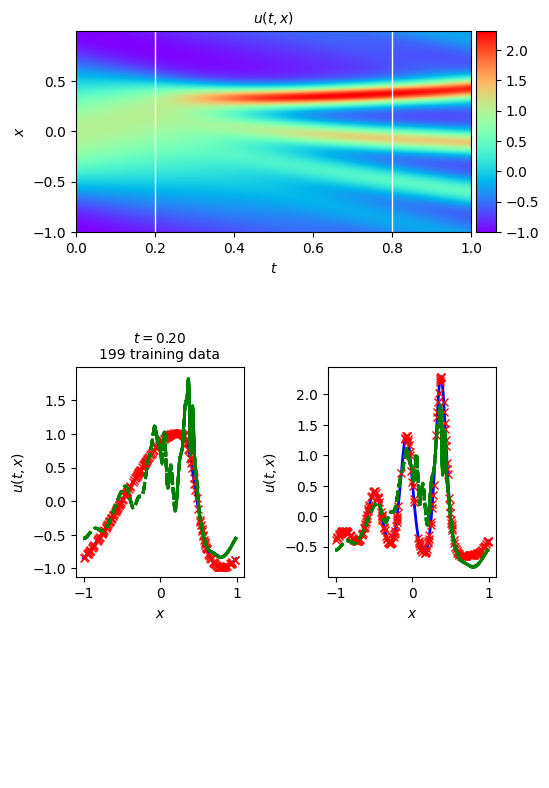

In [29]:
######################################################################
############################### Графики ##############################
######################################################################
def newfig(width, height):
    fig, ax = plt.subplots(figsize=(width * 6, height * 6))  # Масштабируем размеры
    return fig, ax
    
fig, ax = newfig(1.0, 1.5)
ax.axis('off')

# Основной график с точными данными
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3+0.05, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(Exact, interpolation='nearest', cmap='rainbow',
              extent=[t_star.min(), t_star.max(), lb[0], ub[0]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

line = np.linspace(x_star.min(), x_star.max(), 2)[:, None]
ax.plot(t_star[idx_t] * np.ones((2, 1)), line, 'w-', linewidth=1.0)
ax.plot(t_star[idx_t + 120] * np.ones((2, 1)), line, 'w-', linewidth=1.0)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$u(t,x)$', fontsize=10)

# Графики для разных временных моментов
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=1-1/3-0.1, bottom=1-2/3, left=0.15, right=0.85, wspace=0.5)

# Графики для разных временных моментов
ax = plt.subplot(gs1[0, 0])
ax.plot(x_star, Exact[:, idx_t][:, None], 'b', linewidth=2, label='Exact')
ax.plot(x0, u0, 'rx', linewidth=2, label='Data')
# Добавьте прогнозируемые данные
ax.plot(x_star, U0_pred, 'g--', linewidth=2, label='Predicted')  # Прогноз для t = idx_t
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title(f'$t = {t_star[idx_t].item():.2f}$\n{u0.shape[0]} training data', fontsize=10)

ax = plt.subplot(gs1[0, 1])
ax.plot(x_star, Exact[:, idx_t + 120][:, None], 'b', linewidth=2, label='Exact')
ax.plot(x1, u1, 'rx', linewidth=2, label='Data')

# Добавляю прогнозируемые данные
ax.plot(x_star, U1_pred, 'g--', linewidth=2, label='Predicted')  # Прогноз для t = idx_t + 120
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title(f'$t = {t_star[idx_t + 120]:.2f}$\n{u1.shape[0]} training data', fontsize=10)
ax.legend(loc='upper center', bbox_to_anchor=(-0.3, -0.3), ncol=2, frameon=False)

# Таблица с выявленными уравнениями
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=1-2/3-0.05, bottom=0, left=0.15, right=0.85, wspace=0.0)

ax = plt.subplot(gs2[0, 0])
ax.axis('off')
s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct PDE & $u_t + u u_x + 0.0025 u_{xxx} = 0$ \\  \hline Identified PDE (clean data) & '
s2 = r'$u_t + %.3f u u_x + %.7f u_{xxx} = 0$ \\  \hline ' % (lambda_1_value, lambda_2_value)
s3 = r'Identified PDE (1\% noise) & '
s4 = r'$u_t + %.3f u u_x + %.7f u_{xxx} = 0$  \\  \hline ' % (lambda_1_value_noisy, lambda_2_value_noisy)
s5 = r'\end{tabular}$'
s = s1 + s2 + s3 + s4 + s5
ax.text(-0.1, 0.2, s)

# Сохранение графика
# savefig('./figures/KdV')